# Estadística bayesiana con Stan - 03 Modelo normal bivariado

En este notebook se presenta el uso de cmdstanpy para simular muestras de la distribución predictiva de un modelo simple para los parámetros de la distribución normal bivariada.

$$
\mathbf{y}_i \sim Normal_2(\boldsymbol{\mu}, \boldsymbol{\Sigma}), i = 1\ldots, n,
$$

con

$$
\boldsymbol{\mu} =
\begin{bmatrix}
\mu_{1} \\
\mu_{2}
\end{bmatrix}
$$

$$
\boldsymbol{\Sigma} =
\begin{bmatrix}
\tau^2_{1} & \rho \sigma_{1}\tau_{2} \\
\rho \tau_{1}\tau_{2} & \tau^2_{2}
\end{bmatrix}
$$

Con priors

$$
 \mu_i \sim Normal(0, \lambda_i), \quad \tau_i \sim Gamma(\alpha_i, \beta_i), \quad i=1,2, \quad \rho \sim Unif(-1,1),
$$

con $\lambda_i$, $\alpha_i$, $\beta_i$ conocidos

# Setup

In [1]:
# Cargamos los módulos para el análisis
## Manejo de datos y simulación de variable aleatorias
import numpy as np
import pandas as pd

## Gráficas
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

## Simulación bayesiana
from cmdstanpy import CmdStanModel

/home/javolet/miniconda3/envs/pystan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Definición del modelo en Stan

El primer paso es definir el modelo en un archivo independiente y guardarlo en con extensión `'.stan'`.

El script contiene 3 partes: `data`, `parameters` y `model`.

```
data {
    int<lower=0> N;                   // Número de observaciones
    array[N] vector[2] y;             // Datos
    real<lower=1e-3> lambda1;         // Paramétro de la normal 1
    real<lower=1e-3> lambda2;         // Paramétro de la normal 2
    real<lower=1e-3> alpha1;          // Parámetro de la gamma 1
    real<lower=1e-3> beta1;           // Parámetro de la gamma 1
    real<lower=1e-3> alpha2;          // Parámetro de la gamma 2
    real<lower=1e-3> beta2;           // Parámetro de la gamma 2
}
parameters {
    real<lower=1e-3> mu1;                 // Parámetro latente
    real<lower=1e-3> mu2;                 // Parámetro latente
    real<lower=1e-3> tau1;                // Parámetro latente
    real<lower=1e-3> tau2;                // Parámetro latente
    real<lower=-0.999,upper=0.999> rho;   // Parámetro latente
}

transformed parameters {
    vector[2] mu = [mu1, mu2]';          // Vector de medias
    matrix[2,2] Sigma;                   // Matriz de covarianza
    Sigma[1,1] = tau1^2;
    Sigma[1,2] = rho * tau1 * tau2;
    Sigma[2,1] = rho * tau1 * tau2;
    Sigma[2,2] = tau2^2;
}

model {
    mu1 ~ normal(0, lambda1);          // Prior
    tau1 ~ gamma(alpha1, beta1);       // Prior
    mu2 ~ normal(0, lambda2);          // Prior
    tau2 ~ gamma(alpha2, beta2);       // Prior
    rho ~ uniform(-1, 1);

    y ~ multi_normal(mu, Sigma);       // Likelihood
}

generated quantities {
    vector[2] y_new;                   // Muestras simuladas
    y_new = multi_normal_rng(mu, Sigma); 
}
```

# Datos

Para este ejemplo, consideremos que el valor verdadero (?) de $\lambda$ es 5. Simulemos $N=150$ valores de una distribución $Poisson(5)$.

En este ejemplo sencillo, vamos a declarar $\alpha$ y $\beta$ para la distriución inicial (prior) de $\lambda$, de manera uqe sea poco informativa.

Al final creamos un diccionario que usaremos como input para ajustar el modelo con Stan.

In [2]:
np.random.seed(42)
N = 431  # Número de observaciones
N_new = 123 # Número de observaciones a simular de la posterior

# Parametros individuales
mu1, mu2 = 30, 20
tau1, tau2 = 2.3, 1.5
rho = 0.71

# Parametros de la distribución multivarida
mu = [mu1, mu2]  # Media de cada variable
Sigma = [
    [tau1**2, tau1*tau2*rho],   # Matriz de covarianza
    [tau1*tau2*rho, tau2**2]
]

# Simular observaciones
samples = np.random.multivariate_normal(mu, Sigma, size=N)

In [3]:
lambda1, lambda2 = 10, 10 # Parámetros de la distribución normal
alpha1, beta1 = 1, 0.01  # Parámetros de la distribución gamma
alpha2, beta2 = 1, 0.01  # Parámetros de la distribución gamma

# Input del modelo
data = {
    "N": N,
    "N_new": N_new,
    "y": samples.tolist(),
    "lambda1":lambda1,
    "lambda2":lambda2,
    "alpha1": alpha1,
    "beta1": beta1,
    "alpha2": alpha2,
    "beta2": beta2
}

# Compilación del modelo y ajuste (simulación)

Instanciamos el modelo proporcionando la ruta del archivo `.stan`.

In [4]:
model = CmdStanModel(stan_file="bivariate_normal.stan")

fit = model.sample(
    data=data,
    iter_sampling=2000,
    iter_warmup=1000,
    chains=4,
    parallel_chains=4
)

13:53:28 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                                                | 00:00 Status
in 2 |                                                                                                                | 00:00 Status

3 |                                                                                                                | 00:00 Status


                                                                                                                | 00:00 Status
in 2 |████▉                                                                          | 00:00 Iteration:    1 / 3000 [  0%]  (Warmup)

3 |████▉                                                                          | 00:00 Iteration:    1 / 3000 [  0%]  (Warmup)
in 2 |███████▍                                                                       | 00:00 Iteration:  100 / 3000 [  3%]  (Warmup)
in 2 |█████████▉   


13:53:37 - cmdstanpy - INFO - CmdStan done processing.
13:53:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'bivariate_normal.stan', line 30, column 4 to column 32)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'bivariate_normal.stan', line 30, column 4 to column 32)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'bivariate_normal.stan', line 30, column 4 to column 32)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'bivariate_normal.stan', line 30, column 4 to column 32)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'bivariate_normal.stan', line 30, column 4 to column 32)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -nan. (in 'bivariate_normal.stan', line 35, column 4 to column 32)

Podemos imprimir un resumen de la simulación y correr un diágnostico de la simulación.

En este caso podemos observar que hubo problemas en la simulación.

In [5]:
print(fit.summary())

print(fit.diagnose())

                  Mean      MCSE    StdDev       MAD          5%         50%  \
lp__       -796.949000  0.026876  1.592650  1.375850 -800.016000 -796.619000   
mu1          30.020800  0.001263  0.109618  0.108378   29.836500   30.023700   
mu2          20.022900  0.000846  0.072657  0.072796   19.902800   20.023300   
tau1          2.243360  0.001174  0.075390  0.074167    2.121780    2.241210   
tau2          1.499390  0.000796  0.050762  0.051424    1.418860    1.497940   
rho           0.716093  0.000363  0.023956  0.023748    0.675871    0.716428   
mu[1]        30.020800  0.001263  0.109618  0.108378   29.836500   30.023700   
mu[2]        20.022900  0.000846  0.072657  0.072796   19.902800   20.023300   
Sigma[1,1]    5.038340  0.005293  0.339449  0.332362    4.501950    5.023040   
Sigma[1,2]    2.412740  0.003511  0.198719  0.199202    2.105400    2.403210   
Sigma[2,1]    2.412740  0.003511  0.198719  0.199202    2.105400    2.403210   
Sigma[2,2]    2.250760  0.002400  0.1526

Finalmente podemos utilizar arviz para 

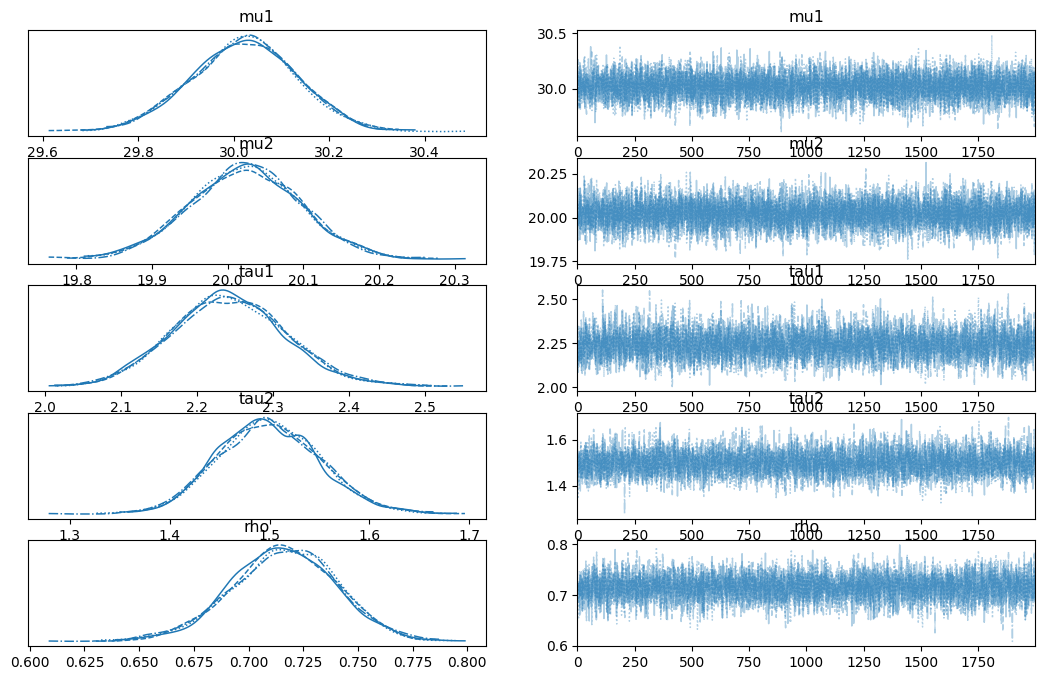

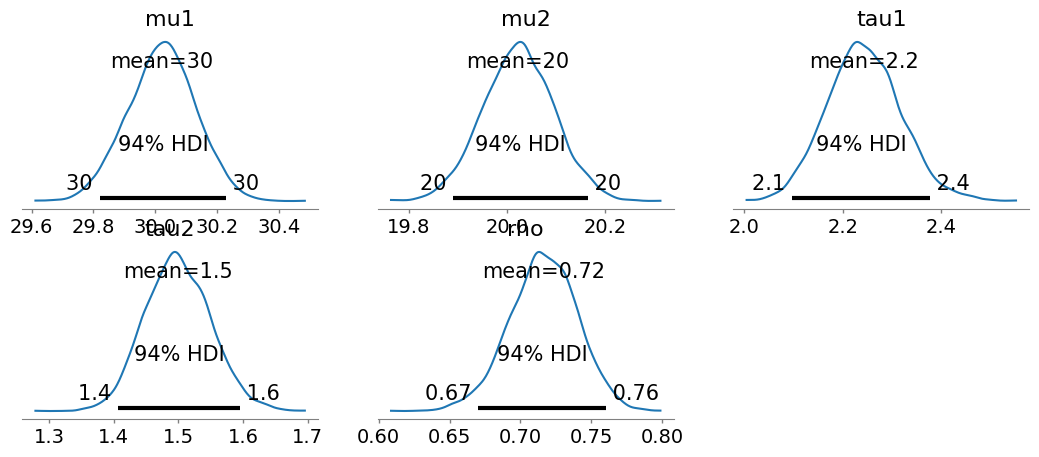

In [6]:
# Convertir la salida de cmdstanpy a un objeto InferenceData
idata = az.from_cmdstanpy(fit)

az.plot_trace(idata, var_names=["mu1","mu2","tau1","tau2","rho"], figsize=(13,8))
plt.show()

# Graficar el posterior de lambda
az.plot_posterior(idata, var_names=["mu1","mu2","tau1","tau2","rho"], figsize=(13,5))
plt.show()

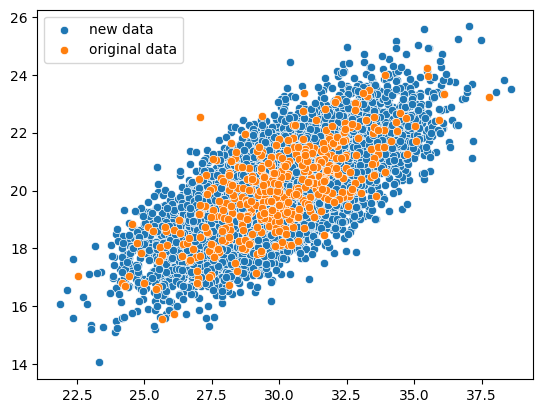

In [7]:
y_new_samples = fit.stan_variable("y_new")

sns.scatterplot(x=y_new_samples[:,0], y=y_new_samples[:,1], label='new data')
sns.scatterplot(x=np.array(samples)[:,0], y=np.array(samples)[:,1], label='original data')
plt.show()